# Evolution de l'émission du centre galactique et de l'émission diffuse

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    SkyDiffuseCube,
    TemplateSpatialModel
)
from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__

'0.15'

Emprunt d'une classe implémentée en 0.16

In [3]:
##FoV background estimation
import logging
from gammapy.maps import Map
from gammapy.modeling import Fit, Datasets


class FoVBackgroundMaker:
    """Normalize template background on the whole field-of-view.

    The dataset background model can be simply scaled (method="scale") or fitted (method="fit")
    on the dataset counts.

    The normalization is performed outside the exclusion mask that is passed on init.

    If a SkyModel is set on the input dataset and method is 'fit', its are frozen during
    the fov normalization fit.

    Parameters
    ----------
    method : str in ['fit', 'scale']
        the normalization method to be applied. Default 'scale'.
    exclusion_mask : `~gammapy.maps.WcsNDMap`
        Exclusion mask
    """

    def __init__(self, method="scale", exclusion_mask=None):
        if method in ["fit", "scale"]:
            self.method = method
        else:
            raise ValueError(f"Incorrect method for FoVBackgroundMaker: {method}.")
        self.exclusion_mask = exclusion_mask


    def run(self, dataset):
        """Run FoV background maker.

        Fit the background model norm

        Parameters
        ----------
        dataset : `~gammapy.cube.fit.MapDataset`
            Input map dataset.

        """
        mask_fit = dataset.mask_fit
        dataset.mask_fit = self._reproject_exclusion_mask(dataset)

        if self.method is "fit":
            self._fit_bkg(dataset)
        else:
            self._scale_bkg(dataset)

        dataset.mask_fit = mask_fit
        return dataset


    def _reproject_exclusion_mask(self, dataset):
        """Reproject the exclusion on the dataset geometry"""
        mask_map = Map.from_geom(dataset.counts.geom)
        if self.exclusion_mask is not None:
            coords = dataset.counts.geom.get_coord()
            vals = self.exclusion_mask.get_by_coord(coords)
            mask_map.data += vals

        return mask_map.data.astype("bool")

    def _fit_bkg(self, dataset):
        """Fit the FoV background model on the dataset counts data"""

        # freeze all model components not related to background model
        datasets = Datasets([dataset])

        parameters_frozen = []
        for par in datasets.parameters:
            parameters_frozen.append(par.frozen)
            if par not in dataset.background_model.parameters:
                par.frozen = True

        #!!!AL: relax titlt : BE CARREFULL !!!
        dataset.background_model.tilt.frozen=False
        
        fit = Fit(datasets)
        fit_result = fit.run()
        if fit_result.success is False:
            print("FoVBackgroundMaker failed. No fit convergence")
            

        # Unfreeze parameters
        for i, par in enumerate(datasets.parameters):
            par.frozen = parameters_frozen[i]

    def _scale_bkg(self, dataset):
        """Fit the FoV background model on the dataset counts data"""
        mask = dataset.mask
        count_tot = dataset.counts.data[mask].sum()
        bkg_tot = dataset.background_model.map.data[mask].sum()

        if count_tot <= 0.0:
            print("FoVBackgroundMaker failed. No counts found outside exclusion mask")
        elif bkg_tot <= 0.0:
            print("FoVBackgroundMaker failed. No positive background found outside exclusion mask")
        else:
            scale = count_tot / bkg_tot
            dataset.background_model.norm.value = scale
            #print("bkg scale = ",scale)

## Fabrication des mapdatasets

Define which data to use and print some information

In [776]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/ash_stereo_Prod17_Calib0834_thsq64")
data_store.info()

Data store:
HDU index table:
BASE_DIR: /home/samuel/code/gammapy_data/ash_stereo_Prod17_Calib0834_thsq64
Rows: 122853
OBS_ID: 18092 -- 151486
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'edisp_2d', 'events', 'gti', 'psf_3gauss', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 20485



In [777]:
from astropy.coordinates import Angle


selection = dict(type='sky_circle', frame='galactic',
                 lon=Angle(0, 'deg'),
                 lat=Angle(0, 'deg'),
                 radius=Angle(2, 'deg'),
                 border=Angle(0, 'deg'))

obs_table = data_store.obs_table.select_observations(selection)

In [778]:
t2004  = dict(type='time_box', time_range= Time(['2004-01-01T00:00:00', '2004-12-31T23:59:59']))
t2005  = dict(type='time_box', time_range= Time(['2005-01-01T00:00:00', '2005-12-31T23:59:59']))
t2006  = dict(type='time_box', time_range= Time(['2006-01-01T00:00:00', '2006-12-31T23:59:59']))
t2007  = dict(type='time_box', time_range= Time(['2007-01-01T00:00:00', '2007-12-31T23:59:59']))
t2008  = dict(type='time_box', time_range= Time(['2008-01-01T00:00:00', '2008-12-31T23:59:59']))
t2009  = dict(type='time_box', time_range= Time(['2009-01-01T00:00:00', '2009-12-31T23:59:59']))
t2010  = dict(type='time_box', time_range= Time(['2010-01-01T00:00:00', '2010-12-31T23:59:59']))
t2011  = dict(type='time_box', time_range= Time(['2011-01-01T00:00:00', '2011-12-31T23:59:59']))
t2012  = dict(type='time_box', time_range= Time(['2012-01-01T00:00:00', '2012-12-31T23:59:59']))
t2013  = dict(type='time_box', time_range= Time(['2013-01-01T00:00:00', '2013-12-31T23:59:59']))
t2014  = dict(type='time_box', time_range= Time(['2014-01-01T00:00:00', '2014-12-31T23:59:59']))
t2015  = dict(type='time_box', time_range= Time(['2015-01-01T00:00:00', '2015-12-31T23:59:59']))
t2016  = dict(type='time_box', time_range= Time(['2016-01-01T00:00:00', '2016-12-31T23:59:59']))
t2017  = dict(type='time_box', time_range= Time(['2017-01-01T00:00:00', '2017-12-31T23:59:59']))
t2018  = dict(type='time_box', time_range= Time(['2018-01-01T00:00:00', '2018-12-31T23:59:59']))
t2019  = dict(type='time_box', time_range= Time(['2019-01-01T00:00:00', '2019-12-31T23:59:59']))

Sélection par année et tri des observations (on retire celles qui n'ont pas toutes les IRF)

In [779]:
year_intervals = { 2004 : t2004, 2005 : t2005, 2006 : t2006, 2007 : t2007,
                      2008 : t2008, 2009 : t2009, 2010 : t2010, 2011 : t2011,
                      2012 : t2012, 2013 : t2013, 2014 : t2014, 2015 : t2015,
                      2016 : t2016, 2017 : t2017, 2018 : t2018, 2019 : t2019}

yearly_obs = dict()

for year in range(2004,2020) :
    
    obs_table_year = obs_table.select_observations(year_intervals[year])
    ids = obs_table_year["OBS_ID"].tolist()
    observations_year = data_store.get_observations(ids, skip_missing=True)
    
    for obs in observations_year:
        try:
            obs.aeff
            obs.edisp
            obs.psf
        except:
            ids.remove(obs.obs_id)
            print("Observation retirée : " + str(obs.obs_id))
            
    observations_year = data_store.get_observations(ids, skip_missing=True)
    yearly_obs[year] = observations_year

Found multiple HDU matching: OBS_ID = 20191, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss
Found multiple HDU matching: OBS_ID = 20193, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss
Found multiple HDU matching: OBS_ID = 20194, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss


Observation retirée : 20191
Observation retirée : 20193
Observation retirée : 20194
Observation retirée : 31539
Observation retirée : 31577
Observation retirée : 31578
Observation retirée : 31579
Observation retirée : 31580


In [780]:
mapdataset_dict = {}

for k in range (2004,2020):
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)

Fabrication des mapdatasets

In [799]:
%%time

exclusion_region = RectangleSkyRegion(src_pos, 3*u.deg, 1*u.deg)
exclusion_mask = geom.region_mask([exclusion_region], inside=False)
exclusion_mask = Map.from_geom(geom, data=exclusion_mask)

for year in range(2004,2020):
    
    offset_max = 2.0 * u.deg
    maker = MapDatasetMaker()
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=offset_max)
    maker_bkg = FoVBackgroundMaker("scale", exclusion_mask)
    
    spectrum = PowerLaw2SpectralModel(index=2.3)

    for obs in yearly_obs[year]:
        # First a cutout of the target map is produced
        cutout = mapdataset_dict[year].cutout(obs.pointing_radec, width=2 * offset_max)

        # A MapDataset is filled in this cutout geometry
        dataset = maker.run(cutout, obs)
        
        # The data quality cut is applied
        dataset = maker_safe_mask.run(dataset, obs)
        
        dataset = maker_bkg.run(dataset)
        
        # The resulting dataset cutout is stacked onto the final one
        mapdataset_dict[year].stack(dataset)

CPU times: user 14min 52s, sys: 1.94 s, total: 14min 54s
Wall time: 14min 54s


Sauvegarde des mapdatasets

In [800]:
from pathlib import Path

#path = Path("$GAMMAPY_DATA/mapdataset_hess/fifth_try")
#path.mkdir(exist_ok=True)

for year in range(2004,2020):
    
    filename = "$GAMMAPY_DATA/mapdataset_hess/mapsdataset_120arcmin_bkg_renorm_alt/mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year].write(filename, overwrite=True)

# Début de l'analyse (avec mapdatasets déjà écrits)

### Création de la géométrie

In [4]:
emin, emax = [0.5, 100] * u.TeV

energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 20, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

energy_axis_true = MapAxis.from_bounds(
    0.1, 200, 20, unit="TeV", name="energy", interp="log"
)

### Lecture des cartes

In [5]:
mapdataset_dict = {}

for k in range (2004,2020):
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)

for year in range(2004,2020):
    
    filename = "$GAMMAPY_DATA/mapdataset_hess/mapsdataset_120arcmin_bkg_renorm/mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year] = MapDataset.read(filename)

### Modèle de la source

In [6]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

spatial_model = PointSpatialModel(
            lon_0 = src_pos.l, 
            lat_0 = src_pos.b, 
            frame = "galactic")

spectral_model = PowerLawSpectralModel(
            #emin = 0.5* u.TeV, 
            #emax = 100* u.TeV, 
            reference = 1.0 * u.TeV,
            index = 2.3, 
            amplitude = "1.5e-12 cm-2 s-1 TeV-1")

model = SkyModel(
            spatial_model = spatial_model, 
            spectral_model = spectral_model, 
            name = "SgrA*")

model.parameters["index"].frozen = True
model.parameters["lon_0"].frozen = True
model.parameters["lat_0"].frozen = True

### Modèle de l'émission diffuse

- on prend une carte de la distribution du CS comme base
- on applique une gaussienne pour "atténuer" les bords, car l'émission de rayons gamma suit la distribution du CS à part aux extrémités du "disque centrale"
- on choisit 0.8 deg comme écart-type de la gaussienne
- on seuil les valeurs de la cartes du CS, car celles-ci viennent de données bruitées qui peuvent prendre des valeurs négatives, on veut a priori seuiller un peu au dessus de zéro pour éliminer le bruit autour de zéro
- valeur du seuil : 10
- le fait d'utiliser TemplateSpatialModel en 0.15 conduit à normaliser les valeurs de la carte par leur somme (normal car on va fiter son amplitude), mais aussi par la somme des angles solides, ce qui fait que le spectre obtenu est en sr-1 emais ce n'est précisé nulle part

In [7]:
CSmap = Map.read("$GAMMAPY_DATA/CS_reproj.fits") 


# à moduler par une gaussienne en longitude
coords = CSmap.geom.get_coord()
lon = coords.skycoord.l.wrap_at(180*u.deg).to_value('deg')
factor = np.exp(-0.5*(lon)**2/0.8**2)


# seuiller les valeurs pour enlever les valeurs négatives liées au bruit
CSmap.data*=factor
CSmap.data = CSmap.data.clip(10.0)

# utile pour retrouver la bonne valeur du flux diffus (intégré sur l'angle solide)
solid_angle_tot = CSmap.geom.solid_angle().sum()

# utile ?
#totalCS = CSmap.quantity*CSmap.geom.solid_angle()
#CSmap.data = CSmap.data/totalCS.value


diffuse_gal = TemplateSpatialModel(CSmap)

#diffuse_gal.parameters["norm"].value = 1.0

powerlaw2 =  PowerLawSpectralModel(
            #emin =0.5* u.TeV, 
            #emax = 100* u.TeV, 
            reference = 1.0 * u.TeV,
            index = 2.3, 
            amplitude = "1e-12 cm-2 s-1 TeV-1")


model_diff = SkyModel(
            spatial_model = diffuse_gal, 
            spectral_model = powerlaw2, 
            name = "DE")

model_diff.parameters["index"].frozen = True
model_diff.parameters["norm"].frozen = True

Invalid value BUNIT='Count' in FITS header. Setting empty unit.


### Construction du masque

In [8]:
fit_region = RectangleSkyRegion(src_pos, 3*u.deg, 1*u.deg)

g0901_region = CircleSkyRegion(SkyCoord(0.8791,  +0.0893, unit="deg", frame="galactic"), 0.1*u.deg)

bizarre_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.4 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([g0901_region ,bizarre_region ] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

# Ajustement du modèle aux cartes

Pour les cartes fabriquées avec le FOVBackgroundMaker : 
- si la norm du background est frozen = emission diffuse est négative
- si la norm du background est pas frozen = emission diffuse est négative au premier essai
- emission diffuse est idem au deuxième essai
- emission diffuse est idem   au troisième essai
- si la norm du background est pas frozen ET qu'on ne refixe pas norm à 1 = emission diffuse est ok/bof au quatrième essai
- si on le refait (toujours sans toucher à la norm mais avec reset des 2 modèles) = c'est bon


En gros, faire le fit une première fois pour avoir la norm juste, puis, sans toucher à la norm, remettre les deux modèles à zéro et refaire le fit, deux fois

si on refait le fit sans mettre les modèles à zéro ? ça change rien (logique car à cette étape le fit est censé être correct)

In [134]:
def fit_dataset(mapdataset):
    fit = Fit([mapdataset])
    result = fit.run()
    
    table = result.parameters.to_table()
    
    rescov = fit.covariance()
    ampSGRA = mapdataset.models.parameters[3]
    ampdiff = mapdataset.models.parameters[7]
    normbkg = mapdataset.background_model.parameters['norm']
    
    cov= rescov.parameters.get_subcovariance([ampSGRA, ampdiff, normbkg])
    
    return table, cov

def fit_dataset_contour(mapdataset):
    fit = Fit([mapdataset])

    fit.optimize()
    res = fit.minos_contour(3, 7)
   
    return res

In [138]:
%%time

for year in range(2004,2020):
    #mapdataset_dict[year].fit_mask = fit_mask
    mapdataset_dict[year].models =  model.copy() + model_diff.copy()
    #mapdataset_dict[year].background_model.parameters['norm'].value = 1.0
    #mapdataset_dict[year].background_model.parameters['norm'].frozen = True
    
results_per_year = dict()
results = []
cov_per_year = dict()


for year in range(2004,2020):
    
    table, cov = fit_dataset(mapdataset_dict[year])
    
    results_per_year[year] = table
    
    cov_per_year[year] = cov
    

CPU times: user 9min 22s, sys: 473 ms, total: 9min 22s
Wall time: 9min 23s


In [140]:
results_per_year[2006]

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,3.599e+02,0.000e+00,deg,nan,nan,True
lat_0,-4.000e-02,0.000e+00,deg,-9.000e+01,9.000e+01,True
index,2.300e+00,0.000e+00,,nan,nan,True
amplitude,1.789e-12,1.218e-13,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
norm,1.000e+00,0.000e+00,,nan,nan,True
index,2.300e+00,0.000e+00,,nan,nan,True
amplitude,2.074e-10,1.517e-11,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


### Sauvegarde des modèles par année

In [141]:
for year in range(2004,2020):
    mapdataset_dict[year].models.write("../../hess_results/13th_try/models/model"+ str(year), overwrite=True)

### Affichage et sauvegarde des résidus

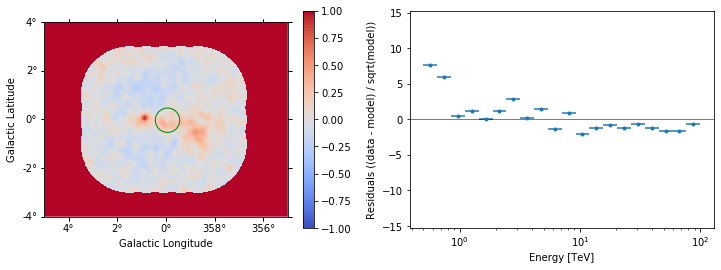

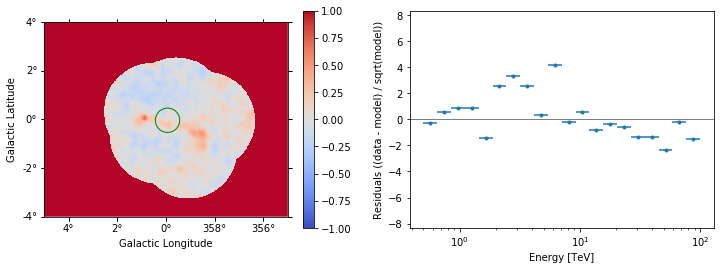

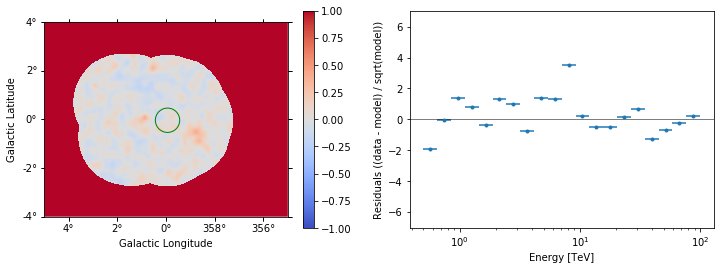

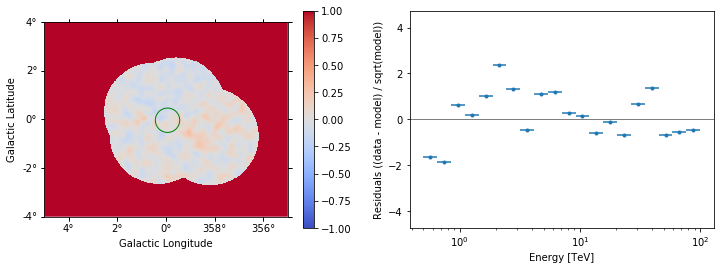

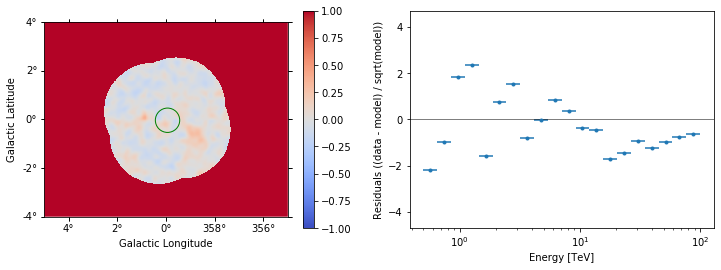

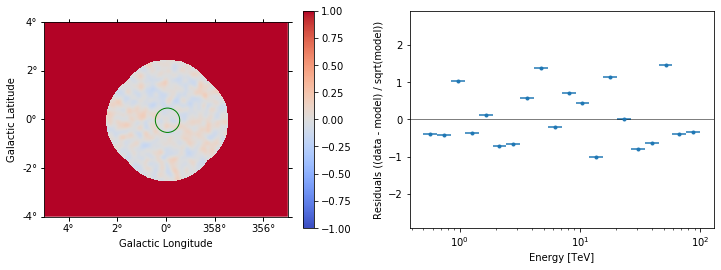

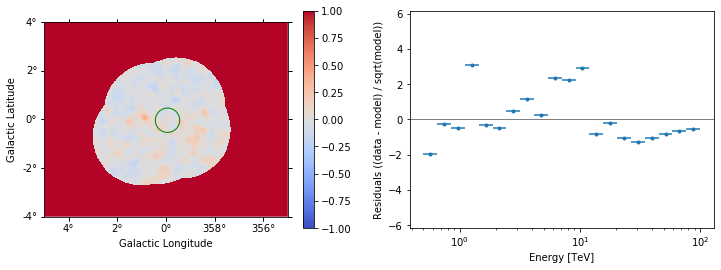

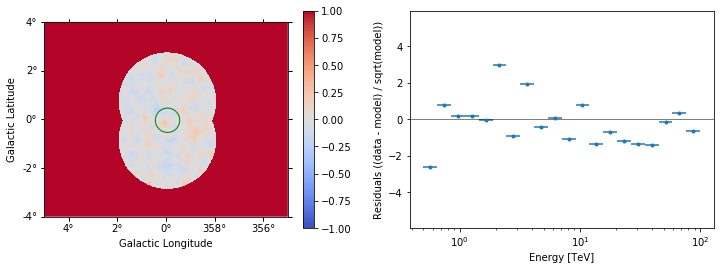

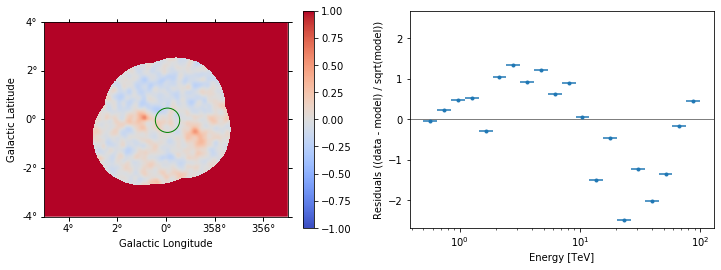

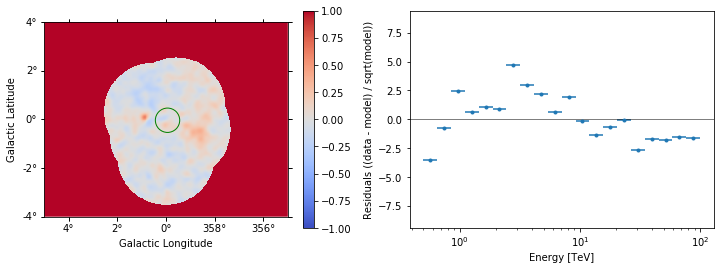

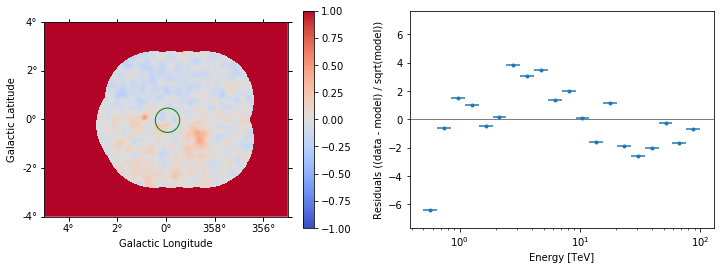

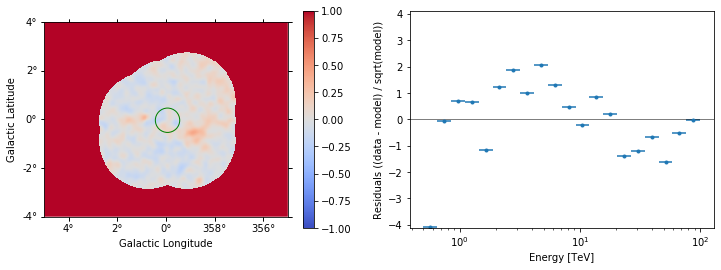

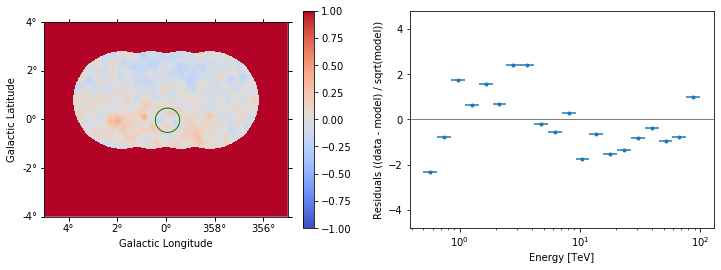

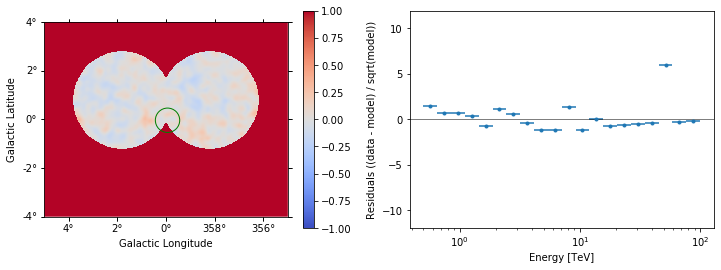

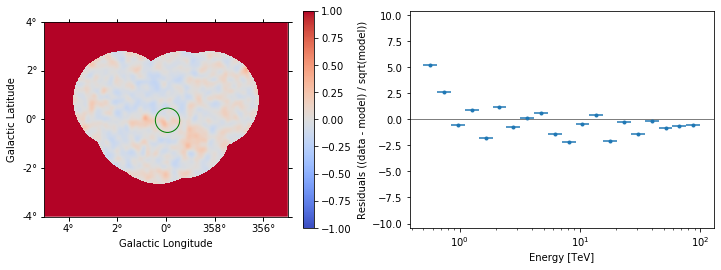

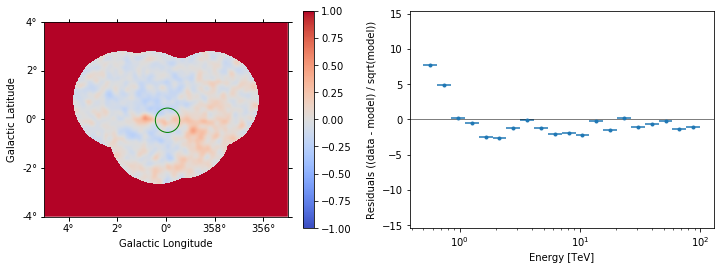

In [142]:
region = CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)

for year in range(2004,2020):
    mapdataset_dict[year].plot_residuals(
        region=region, method="diff/sqrt(model)", vmin=-1.0, vmax=1.0
        )
    plt.savefig("../../hess_results/13th_try/residuals/residuals_"+str(year)+".pdf", overwrite=True)


## Etude de l'évolution temporelle de la source/du diffus

In [143]:
def CalculateFluxFromModels(year, emin, emax):
    GC_model,diffuse_model  = mapdataset_dict[year].models
    
    amplitudeGC = results_per_year[year]['value'][3]
    amp_errGC = results_per_year[year]['error'][3]
    amplitudediff = results_per_year[year]['value'][7]
    amp_errdiff = results_per_year[year]['error'][7]
    
    if isinstance(emin, u.Quantity):
        #il faut convertir le flux du diffus qui est en sr-1, 
        # donc intégrer sur tout l'angle solide du template (opération inverse de celle effectuée par TamplateSpatialModel)
        
        diffuse_flux = diffuse_model.spectral_model.integral(emin, emax)#*solid_angle_tot  
        GC_flux = GC_model.spectral_model.integral(emin, emax)
        
    if np.isscalar(emin):
        emin = emin*u.TeV
        emax = emax*u.TeV
        diffuse_flux = diffuse_model.spectral_model.integral(emin, emax)
        GC_flux = GC_model.spectral_model.integral(emin, emax)
    
    return diffuse_flux, GC_flux, amplitudeGC, amp_errGC, amplitudediff, amp_errdiff

    #diffuse_index = diffuse_model.spectral_model.index.value
    #diffuse_amp = diffuse_model.spectral_model.amplitude.value
    
    #GC_index = GC_model.spectral_model.index.value
    #GC_amp = GC_model.spectral_model.amplitude.value
     

### Tracé de l'évolution

Problèmes actuels :
- l'émission diffuse varie trop (au moins du simple au double)
- l'émission diffuse n'est plus calculabe à partir de 2017
- l'émission diffuse croit "linéairement" en deux temps, pourquoi ?
- le flux de la source évolue clairement avec le flux du diffus, c'est attendu mais cela implique que les valeurs calculées pour le flux de la source sont faussés.
- le fond a une normalisation qui varie trop apparemment

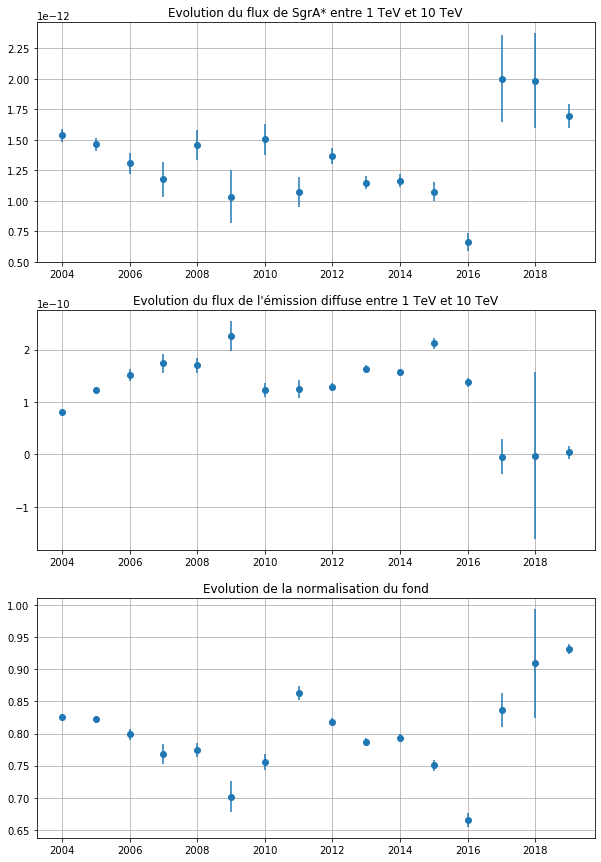

In [144]:
emin = 1.0*u.TeV
emax = 10*u.TeV
resGC = []
resdiff = []
ampsGC = []
amp_errsGC = []
ampsdiff = []
amp_errsdiff = []
norms = []
norms_err = []


for year in range(2004,2020):
    dif , GC, amp, amp_err, ampdiff, amp_errdiff = CalculateFluxFromModels(year, emin, emax)
    
    resGC.append(GC.value)
    resdiff.append(dif.value)
    ampsGC.append(amp)
    amp_errsGC.append(amp_err)
    ampsdiff.append(ampdiff)
    amp_errsdiff.append(amp_errdiff)
    
    norms.append(results_per_year[year][9]['value'])
    norms_err.append(results_per_year[year][9]['error'])

plt.figure(figsize=(10,15))

resGC = np.asarray(resGC)
ampsGC = np.asarray(ampsGC)
amp_errsGC = np.asarray(amp_errsGC)
resdiff = np.asarray(resdiff)
ampsdiff = np.asarray(ampsdiff)
amp_errsdiff = np.asarray(amp_errsdiff)

yerrGC = (resGC/ampsGC)*amp_errsGC
yerrdiff = (resdiff/ampsdiff)*amp_errsdiff


ax1 = plt.subplot(3,1,1)

plt.errorbar(range(2004,2020) , resGC, yerr=yerrGC, fmt='o')# ax=ax1)
plt.title("Evolution du flux de SgrA* entre 1 TeV et 10 TeV")
plt.grid()

ax2 = plt.subplot(3,1,2)
plt.errorbar(range(2004,2020) , resdiff, yerr=yerrdiff, fmt='o')
plt.title("Evolution du flux de l'émission diffuse entre 1 TeV et 10 TeV")
plt.grid()


ax3 = plt.subplot(3,1,3)
plt.errorbar(range(2004,2020) , norms, yerr=norms_err, fmt='o')# ax=ax1)
plt.title("Evolution de la normalisation du fond")
plt.grid()

plt.savefig("../../hess_results/13th_try/GCDEflux_evolution_normfixe_indexfixe_seuil.pdf")

## Ajustement du modèle d'évolution grâce à astropy

In [145]:
import scipy.stats as stats

from astropy.modeling import models, fitting

def chisq(obs, exp):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(exp**2)
    return chisq


def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp)**2)/(error[i]**2)
    return chisqr

### Ajustement de l'évolution de la source

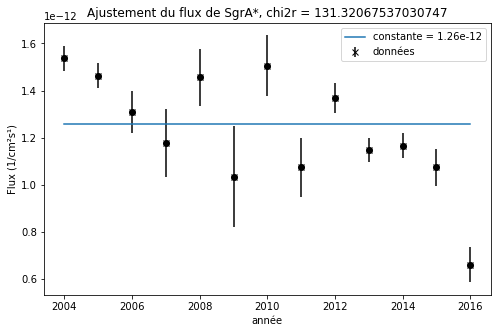

In [146]:
x = range(2004,2020)
y = resGC
y_uncs = yerrGC

x = np.delete(x, [13,14,15])
y = np.delete(y, [13,14,15])
y_uncs = np.delete(y_uncs, [13,14,15])


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-12)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = np.delete(resGC, [13,14,15])
A2 = t(2004)
err_bars = yerrGC
chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)


# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('année')
plt.ylabel('Flux (1/cm²s¹)')
plt.legend(loc=1)
plt.title("Ajustement du flux de SgrA*, chi2r = " + str(chi2r))
plt.savefig("../../hess_results/13th_try/2004-2016/fit_flux_SgrAstar_04_16.pdf")

### Ajustement de l'émission diffuse

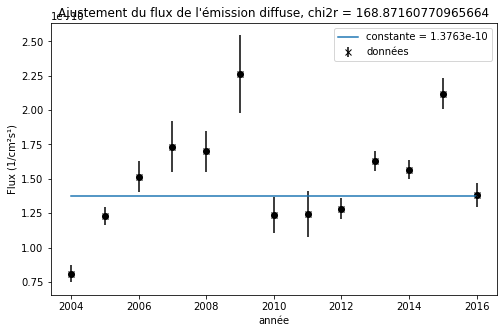

In [147]:
x = range(2004,2020)
y = resdiff
y_uncs = yerrdiff

x = np.delete(x, [13,14,15])
y = np.delete(y, [13,14,15])
y_uncs = np.delete(y_uncs, [13,14,15])


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-10)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)

A1 = np.delete(resdiff, [13,14,15])
A2 = t(2004)
err_bars = yerrdiff
chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('année')
plt.ylabel('Flux (1/cm²s¹)')
plt.legend(loc=1)
plt.title("Ajustement du flux de l'émission diffuse, chi2r = " + str(chi2r))
plt.savefig("../../hess_results/13th_try/2004-2016/fit_flux_DE_04_16.pdf")

### On regarde le rapport entre les 2

/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


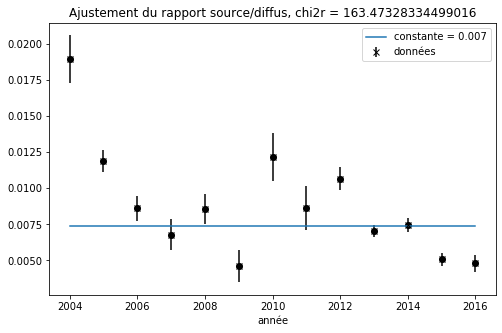

In [152]:
x = range(2004,2020)
y = resGC/resdiff

bizar = []
for k in range(16):
    truc = 2*(cov_per_year[2004+k][0,1]*yerrGC[k]*yerrdiff[k])/(resGC[k]*resdiff[k])
    bizar.append(truc)
    
# erreurs quadratiques trop simplistes car les jeux de données sont corrélées
y_uncs = y*np.sqrt((yerrGC/resGC)**2 + (yerrdiff/resdiff)**2 -bizar )

x = np.delete(x, [13,14,15])
y = np.delete(y, [13,14,15])
y_uncs = np.delete(y_uncs, [13,14,15])

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(0.6)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)


A1 = np.delete(y, [13,14,15])
A2 = t(2004)
err_bars = y_uncs
chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)


# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 3)) )
plt.xlabel('année')
plt.ylabel('')
plt.legend(loc=1)

plt.title("Ajustement du rapport source/diffus, chi2r = " + str(chi2r))
plt.savefig("../../hess_results/13th_try/2004-2016/fit_flux_GCsurDE_04_16.pdf")

In [150]:
cov_per_year[2004][0,1]

-1.9394799580837315e-25

## Autres choses

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fdde4b3e9b0>)

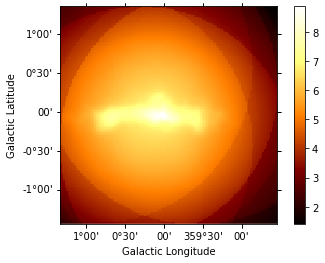

In [879]:
mapdataset_dict[2004].models[0].parameters['amplitude'].value = 0

mapdataset_dict[2004].npred().sum_over_axes().cutout(src_pos,2.8*u.deg).plot(add_cbar=True)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fdde41e4dd8>)

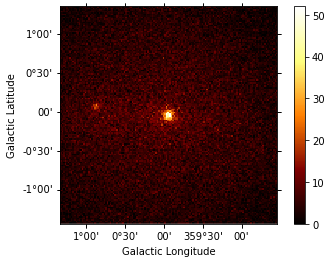

In [875]:
mapdataset_dict[2004].counts.sum_over_axes().cutout(src_pos,2.8*u.deg).plot(add_cbar=True)

In [877]:
results_per_year[2004]

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,3.599e+02,0.000e+00,deg,nan,nan,True
lat_0,-4.000e-02,0.000e+00,deg,-9.000e+01,9.000e+01,True
index,2.300e+00,0.000e+00,,nan,nan,True
amplitude,2.102e-12,7.514e-14,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
norm,1.000e+00,0.000e+00,,nan,nan,True
index,2.300e+00,0.000e+00,,nan,nan,True
amplitude,1.109e-10,8.875e-12,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
